# Лабораторная работа 1. Классические методы построения рекомендаций.

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit.

Вопросы по заданию можно писать в чат курса или на почту, которая будет дана в чате курса. Ссылка на форму для отправки решений будет дана в чате.

In [218]:
import pandas as pd
import numpy as np

In [219]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [220]:
!pip install rs-datasets

In [221]:
from rs_datasets import MovieLens

In [222]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


В моделях мы работаем с индексами объектов (в нашем случае -- фильмов), для удобства сделаем конвертацию индекса фильма в его название, для просмотра результата рекомендаций в человеко-читаемом виде.

In [223]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [224]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(8) #! the parametr represents amount of table lines

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59


Рассмотрим распределение по оценкам, которые пользователи дают фильмам. Из графика видно, что чаще всего люди дают оценки 4 или 3 (середина рейтинговой шкалы).

<BarContainer object of 5 artists>

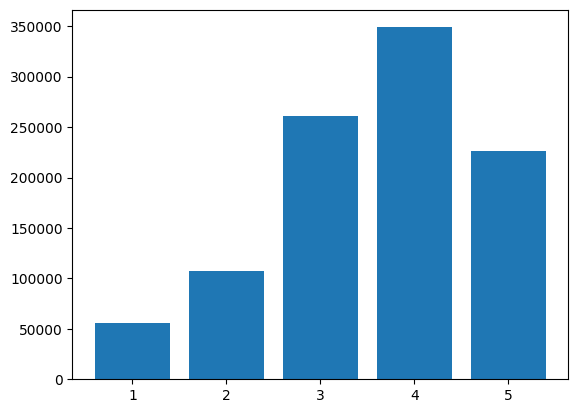

In [225]:
import matplotlib.pyplot as plt
# построим распределение оценок
grp = reviews.groupby('relevance')
marks_count = grp.size().tolist()
plt.bar(range(1, len(marks_count)+1), marks_count)

Построим график частоты оценивания фильмов -- насколько много пользователи оценивали фильмы в промежутке с 2000 по 2003 год. На графике можно четко видет два ярких пика активности. Из графика становится понятно, почему в задании просят разделить данные на тренировочную и валидационную выборки именно таким образом (данные до 1 декабря 2000 года не включая - данные train, данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные).

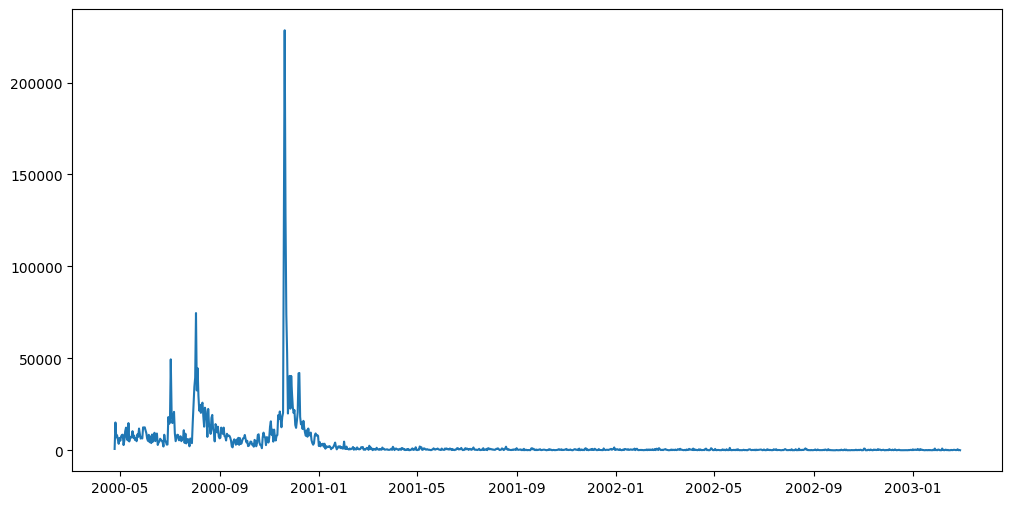

In [226]:
df = reviews.groupby(pd.Grouper(key='timestamp', axis=0,
                      freq='1D', sort=True)).sum()
plt.figure(figsize=(12, 6))
plt.plot(df['relevance'])

Заведем вспомогательную функцию для анализа квантилей оценок на пользователя и на фильм.

In [228]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

Построим график, по которому оценим, на сколько часто пользователи оценивают фильмы. По шкале абцис -- количество оценок, по оси ординат -- количество пользователей, которые ставят не более такого количество. Из графика можно сделать следующие выводы:
- все пользователи в таблице дали хотя бы 20 оценок (нет мертвых пользователей)
- в основном количество оценок, даваемое пользователем не привышает 200
- мало пользователей ставит большое количество оценок

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
5%         23.000000
25%        44.000000
50%        96.000000
75%       208.000000
95%       556.000000
max      2314.000000
Name: relevance, dtype: float64


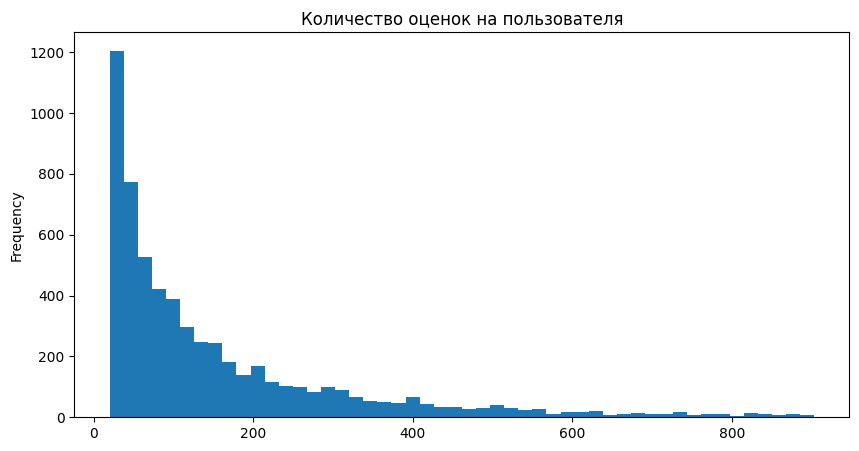

In [229]:
user_count = group_by_and_plot(reviews, group_by_name='user_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на пользователя')

Построим график, по которому оценим, на сколько часто оценивается каждый фильм.По шкале абцис -- количество оценок, по оси ординат -- фильмов, которые оцениваются не более чем таким количеством оценок. Из графика можно сделать следующие выводы:
- каждый фильм получил хотя бы по одной оценке
- в основном один фильм оценивается не более 250 раз
- мало фильмов имеет большое количество оценок

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
5%          2.000000
25%        33.000000
50%       123.500000
75%       350.000000
95%      1051.500000
max      3428.000000
Name: relevance, dtype: float64


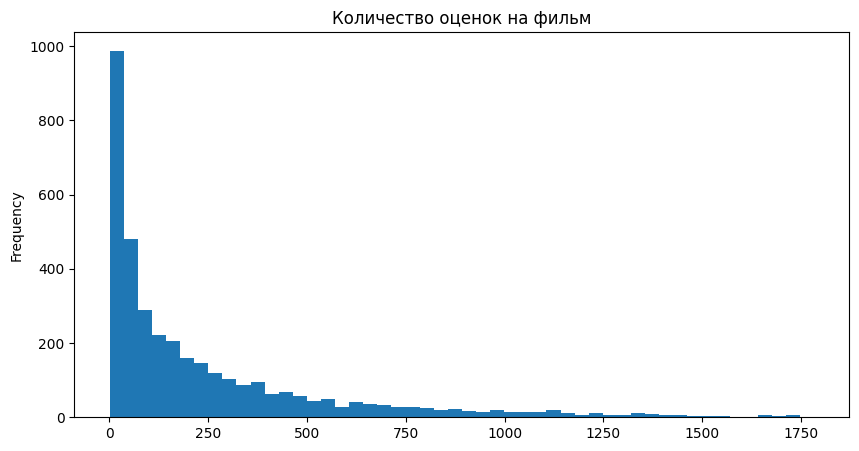

In [230]:
item_count = group_by_and_plot(reviews, group_by_name='item_id', rating_col_name='relevance', quantile=0.99, title='Количество оценок на фильм')

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

Разделим датасет на train и validation

In [231]:
train = reviews.loc[reviews['timestamp'] < '2000-12-01']
test  = reviews.loc[reviews['timestamp'] <= '2000-12-31'].loc[reviews['timestamp'] >= '2000-12-01']
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)

Train Dataset: (791270, 4)
Test Dataset: (111315, 4)


Из валидационного датасета удалим неудовлетворительные оценки. Удовлетворительными считаются оценки 4 и 5. Таким образом, в валидационном датасете остались только те пары user-item, которые имеют положительный relevance.

In [232]:
test = test[test['relevance'] > 3]
print('Train Dataset:', train.shape)
print('Test Dataset:', test.shape)
test.head(10)

Train Dataset: (791270, 4)
Test Dataset: (64036, 4)


,user_id,item_id,relevance,timestamp
1205,11,1188,4,2000-12-30 23:51:59
1217,11,1198,4,2000-12-30 23:28:33
1218,11,593,5,2000-12-30 23:40:07
1226,11,1923,5,2000-12-30 23:53:13
1227,11,2580,5,2000-12-30 23:47:10
1228,11,1784,5,2000-12-30 23:45:17
1229,11,318,5,2000-12-30 23:39:07
1232,11,1358,5,2000-12-30 23:42:56
1241,11,3105,5,2000-12-30 23:41:42
1244,11,764,5,2000-12-30 23:44:29


После деления по времени в валидации могут оказаться пользователи, отсутствующие в train. Их считаем холодными (модель их не видела при обучении) и удаляем из валидационной части.

In [233]:
from tqdm import tqdm
train_users_set = set(train['user_id'].tolist())
test_users_set = set(test['user_id'].tolist())
set_intersection = train_users_set.intersection(test_users_set)

for usr in tqdm(test_users_set):
  if usr not in set_intersection:
    idx = test[test['user_id'] == usr].index
    idx.tolist()
    test = test.drop(idx.tolist())

100%|██████████| 1181/1181 [00:07<00:00, 162.23it/s]


In [234]:
# YOUR CODE HERE
train = train
val = test

In [235]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

Сделаем отдельный тренировочный набор толко с положительными оценками (понадобится для дальнейших заданий)

In [236]:
positive_train = train[train['relevance'] > 3]

Заведем тестового юзера, на котором будем простатривать работу моделей. А так же тестовый item, на котором будем смотреть результат работы метода most_similar моделей из библиотеки implicit.

In [237]:
TEST_USER_ID = 670
TEST_ITEM_ID = 1248

Заведем вспомогательную функцию, которая позволяет посмотреть список фильмов, которые оценивал указанный пользователь, чтобы сравнить их потом с рекомендованными фильмами.

In [238]:
def get_user_group(user_id, df):
  grouped = df.groupby('user_id')
  for user_group in grouped: #! not optimal
    if user_group[1]['user_id'].tolist()[0] == user_id: #! not optimal
      return user_group
  return None

def get_user_marked_items(user_id, df):
  test_usr_group = get_user_group(user_id, df)
  assert(test_usr_group != None)
  user_marked_items_idx = test_usr_group[1]['item_id'].tolist()

  df = data.items[data.items['item_id'].isin(user_marked_items_idx)]
  return df

In [240]:
get_user_marked_items(TEST_USER_ID, train)

,item_id,title,genres
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
72,73,"Misérables, Les (1995)",Drama|Musical
109,111,Taxi Driver (1976),Drama|Thriller
287,290,Once Were Warriors (1994),Crime|Drama
309,312,Stuart Saves His Family (1995),Comedy
...,...,...,...
3841,3911,Best in Show (2000),Comedy
3845,3915,Girlfight (2000),Drama
3865,3935,Kronos (1973),Horror
3878,3948,Meet the Parents (2000),Comedy


In [239]:
get_user_marked_items(TEST_USER_ID, val)

,item_id,title,genres
896,908,North by Northwest (1959),Drama|Thriller
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1229,1249,Nikita (La Femme Nikita) (1990),Thriller
1230,1250,"Bridge on the River Kwai, The (1957)",Drama|War
1239,1259,Stand by Me (1986),Adventure|Comedy|Drama
2555,2624,After Life (1998),Drama


In [241]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [242]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [243]:
import random

Сгенерируем для каждого пользователя из валидационной выборки 20 рандомных рекомендаций. Так же каждой рандомной рекомендации приписываем рандомный relevance.

In [247]:
def get_n_random_items(n):
  random_items = data.items.sample(n=n, random_state=random.randint(0, 100))
  random_items_idx = random_items['item_id'].tolist()
  return random_items_idx

def make_random_pred(user_list, dataset, N):
  df = pd.DataFrame()
  for user_id in tqdm(user_list):
    random_items = get_n_random_items(N)
    for item in random_items:
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      # in this task we assume that we make a random relevance to recommended item
      new_row['relevance'] = random.randint(1, 5)
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

In [248]:
%%time
# YOUR CODE HERE
user_list = set(val['user_id'].tolist())
random_pred = make_random_pred(user_list, train, K)
random_pred.head(10)

100%|██████████| 522/522 [00:10<00:00, 51.19it/s]

CPU times: user 9.9 s, sys: 133 ms, total: 10 s
Wall time: 10.2 s


,user_id,item_id,relevance
0,2050,2785,5
0,2050,2028,4
0,2050,396,4
0,2050,1912,4
0,2050,1329,5
0,2050,1296,1
0,2050,1406,5
0,2050,2794,5
0,2050,1895,5
0,2050,998,2


In [249]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [250]:
random_pred.head(1)

,user_id,item_id,relevance
0,2050,2785,5


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [251]:
import math

In [252]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    Reli = len(row['gt_list'])
    pred_list = row['pred_list']
    dcg = 0
    counter = 0
    for j, item in enumerate(pred_list):
      if counter >= k: break
      counter += 1
      if item in row['gt_list']:
        dcg += 1 / (math.log2(j+1+1))

    idcg = 0
    counter = 0
    for j in range(Reli):
      if counter >= k: break
      counter += 1
      idcg += 1 / (math.log2(j+1+1))

    if idcg == 0: return 0
    ndcg = dcg / idcg
    return ndcg

In [253]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [254]:
def leave_top_k(pred: pd.DataFrame,
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False)) #? if here we wan to predict the most relevance items, so we put the ascending=True
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [255]:
# YOUR CODE HERE: оценка NDCG для всех пользователей. На вход приходят рекомендации в формате как в задании 3
def nDCG(pred, true, k):
  pred_cropped = leave_top_k(pred, k)
  # prepare score lists
  pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
  gt_grouped = true.groupby('user_id')['item_id'].apply(list).rename('gt_list')
  to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
  to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else []) # если нет оценок, записываем пустой лист (хотим сделать так, чтобы в ячейках датафрэйма лежали листы)

  sumNDCG = 0
  N = pred['user_id'].nunique()
  for _, row in to_compare.iterrows():
    sumNDCG += ndcg_user(row, k)
  return sumNDCG / N

Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [256]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        # в этом словаре мы для каждого item_id сохраним количество пользователей, которые оценивали этот item
        self.items_marks_count = {}
        self.N = log['user_id'].nunique() # число пользователей в обучающей выборке

        grouped = log.groupby('item_id')
        for grp in grouped:
          marks_count = grp[1]['user_id'].count()
          self.items_marks_count[grp[1]['item_id'].tolist()[0]] = marks_count # not optimal

    def get_item_self_info(self, item_id):
      # учитываем холодные items
      if item_id in self.items_marks_count.keys():
        return -math.log2(self.items_marks_count[item_id] / self.N)
      else:
        return -math.log2(1 / self.N)

    def __call__(self, pred, k):
        top_k_pred = leave_top_k(pred, k)
        surprisal = 0

        uniq_users_amount = top_k_pred['user_id'].nunique()
        grouped = top_k_pred.groupby('user_id')
        for grp in grouped:
          sum_self_info = grp[1]['item_id'].apply(self.get_item_self_info)
          sum_self_info = sum_self_info.sum()
          # k_marks = grp[1]['user_id'].count()
          # surprisal += sum_self_info / (math.log2(self.N) * k_marks)
          surprisal += sum_self_info / (math.log2(self.N) * k)
        return surprisal / uniq_users_amount

In [257]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

Создадим объект с предподсчитанной статистикой по тренеровочной выбоке.

In [258]:
surp = Surprisal(train)

In [259]:
from copy import deepcopy

In [260]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

def HitRate(pred, ground_truth, k):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    HR = to_compare.apply(user_hr, axis=1)
    return HR.mean()

Для каждой метрики заведем словарь. В словаре будем хранить имя модели и значение соответствующей матрики.

In [261]:
HIT_RATE = {}
COVERAGE = {}
N_DCG = {}
SURPRISAL = {}

In [262]:
COVERAGE['random'] = coverage(random_pred, K, train['item_id'].drop_duplicates())
HIT_RATE['random'] = HitRate(random_pred, val, K)
N_DCG['random'] = nDCG(random_pred, val, K)
SURPRISAL['random'] = surp(random_pred, K)

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

Сделаем вспомогательную функцию, которая принимает модель, количество запрашиваемых рекомендаций и матрицу user-item для генерации рекомендаций (передаем валидационные данные).

In [263]:
def make_recommendation_table(user_list, model, N, user_item_matrix):
  df = pd.DataFrame()
  for user_id in tqdm(user_list):
    # get a list of recommended items for specific user
    # recommended_items = model.recommend(user_id,
    #                     user_items=csr_matrix(user_item_matrix).tocsr(),
    #                     N=N,
    #                     filter_already_liked_items=False,
    #                     filter_items=None,
    #                     recalculate_user=True)
    for item, rel in zip(recommended_items[0], recommended_items[1]):
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      new_row['relevance'] = rel
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

In [348]:
def make_recommendation_table(user_list, model, N, user_item_matrix):
  recomendations, weights = model.recommend(user_list,
                                   csr_matrix(user_item_matrix[list(user_list)]), N=N,
                                   filter_already_liked_items=True,
                                   filter_items=None,
                                   recalculate_user=True)
  df = pd.DataFrame({'user_id': np.array(list(user_list)).repeat(N), 'item_id': recomendations.reshape(-1), 'relevance': weights.reshape(-1)})
  for col, dtype in zip(['user_id', 'item_id', 'relevance'], (np.int32, np.int32, np.float32)):
        df[col] = df[col].astype(dtype)

  return df

In [264]:
! pip install implicit

In [265]:
import implicit

Создадим несколько моделей с различными значениями гиперпараметров (в нашем случае -- количество соседей), чтобы исследовать влияние гиперпараметра на оценку модели.

In [311]:
# knn_model_10 = implicit.nearest_neighbours.CosineRecommender(10)
# knn_model_50 = implicit.nearest_neighbours.CosineRecommender(50)
# knn_model_100 = implicit.nearest_neighbours.CosineRecommender(100)
# knn_model_200 = implicit.nearest_neighbours.CosineRecommender(200)
# knn_model_300 = implicit.nearest_neighbours.CosineRecommender(300)
# knn_model_400 = implicit.nearest_neighbours.CosineRecommender(400)
# knn_model_500 = implicit.nearest_neighbours.CosineRecommender(500)
# knn_model_600 = implicit.nearest_neighbours.CosineRecommender(600)
# knn_model_700 = implicit.nearest_neighbours.CosineRecommender(700)
# knn_model_800 = implicit.nearest_neighbours.CosineRecommender(800)
# knn_model_900 = implicit.nearest_neighbours.CosineRecommender(900)

In [312]:
knn_models_list = [
    knn_model_10,
    knn_model_50,
    knn_model_100,
    knn_model_200,
    knn_model_300,
    knn_model_400,
    knn_model_500,
    knn_model_600,
    knn_model_700,
    knn_model_800,
    knn_model_900
  ]

Внутри моделей implicit жестко захардкожены названия полей: datetime вместо timestamp, weight вместо relevance. Без этого модели выдают ошибку.

In [266]:
train.rename(columns={"timestamp": "datetime"}, inplace=True)
train.rename(columns={"relevance": "weight"}, inplace=True)

val.rename(columns={"timestamp": "datetime"}, inplace=True)
val.rename(columns={"relevance": "weight"}, inplace=True)

<ipython-input-266-976deb36a56a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"timestamp": "datetime"}, inplace=True)
<ipython-input-266-976deb36a56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={"relevance": "weight"}, inplace=True)


Issue 167 в пакете implicit, необходимо привести веса к типу float, иначе метод recommend выдает ошибку.

In [267]:
val['weight'] = pd.to_numeric(val['weight'], downcast='float')
train['weight'] = pd.to_numeric(train['weight'], downcast='float')

<ipython-input-267-ee60b2884c59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight'] = pd.to_numeric(train['weight'], downcast='float')


На вход моделям из пакета implicit нужно подавать матрицу user-item. А нас изначально в датасете таблицы другого вида. Поэтому нужно имеющиеся данные преобразовать к матрице user-item.

Если формировать реальные матрицы, они будут сильно разреженные, большую часть оперативной памяти будут занимать бесполезные нули (на тех местах, где юзеры никак не взаимодействовали с обхектами). Поэтому сформируем sparse матрицы, что позволит нам оптимизировать обучение и экономить место в памяти (аналог использования списка связности вместо матрицы связности в графах).

In [268]:
# from scipy.sparse import csr_matrix

# user_item_train_matrix = pd.pivot_table(train,
#                                   index='user_id',
#                                   columns='item_id',
#                                   values='weight',
#                                   aggfunc='mean',
#                                   fill_value=0)

# user_item_train_matrix = user_item_train_matrix.astype(float)
# sparse_user_item_train = csr_matrix(user_item_train_matrix).tocsr()
# user_item_train_matrix.head(3)

item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [321]:
import implicit
from collections import defaultdict
from scipy.sparse import csr_matrix, dok_matrix

In [323]:
%%time
user_num = train["user_id"].max() + 1
item_num = train["item_id"].max() + 1

train_mat = defaultdict(float)
for _, user, item, rel in train[["user_id", "item_id", "weight"]].itertuples():
    # if rel > 3:
    train_mat[user, item] = rel
rating_matrix = dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(rating_matrix, train_mat)

CPU times: user 1.16 s, sys: 256 ms, total: 1.42 s
Wall time: 1.42 s


In [324]:
user_item_train_matrix = rating_matrix

In [269]:
# user_item_val_matrix = pd.pivot_table(val,
#                                   index='user_id',
#                                   columns='item_id',
#                                   values='weight',
#                                   aggfunc='mean',
#                                   fill_value=0)

# user_item_val_matrix = user_item_val_matrix.astype(float)
# sparse_user_item_val = csr_matrix(user_item_val_matrix).tocsr()
# user_item_val_matrix.head(3)

item_id,1,2,3,4,5,6,7,10,11,12,...,3929,3930,3932,3936,3937,3947,3948,3949,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [327]:
# neighbours_amnt = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]
neighbours_amnt = range(3, 30, 3)
coverage_list = []
n_dcg_list = []
hit_rate_list = []
surprise_list = []

In [329]:
knn_models_list = []
for n in neighbours_amnt:
  model = implicit.nearest_neighbours.CosineRecommender(n)
  knn_models_list.append(model)

Обучим все модели, сделаем предсказания с их помощью и посмотрим, как изменяются метрики качества в зависимости от параметра K модели.

In [333]:
for knn_model in tqdm(knn_models_list):
  knn_model.fit(user_item_train_matrix,
          show_progress=True)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03770136833190918 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:01<00:15,  1.94s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03664398193359375 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:03<00:13,  1.94s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.037985801696777344 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:05<00:11,  1.97s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03718924522399902 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:08<00:10,  2.05s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04602670669555664 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:10<00:08,  2.25s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04660201072692871 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [00:13<00:06,  2.29s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.036783456802368164 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 78%|███████▊  | 7/9 [00:14<00:04,  2.18s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.036296844482421875 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

 89%|████████▉ | 8/9 [00:16<00:02,  2.11s/it]/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03698849678039551 seconds
  warnings.warn(


  0%|          | 0/3953 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:18<00:00,  2.11s/it]


Обучим все модели из списка.

In [349]:
for knn_model in knn_models_list:
  recommendation_table = make_recommendation_table(user_list, knn_model, K, user_item_train_matrix)

  coverage_list.append(coverage(recommendation_table, K, train['item_id'].drop_duplicates()))
  n_dcg_list.append(nDCG(recommendation_table, val, K))
  hit_rate_list.append(HitRate(recommendation_table, val, K))
  surprise_list.append(surp(recommendation_table, K))

Построим графики зависимости каждой из 4 метрик от величины гиперпараметра модели.

Text(0.5, 1.0, 'Зависимость метрики Surprisal от количества соседей')

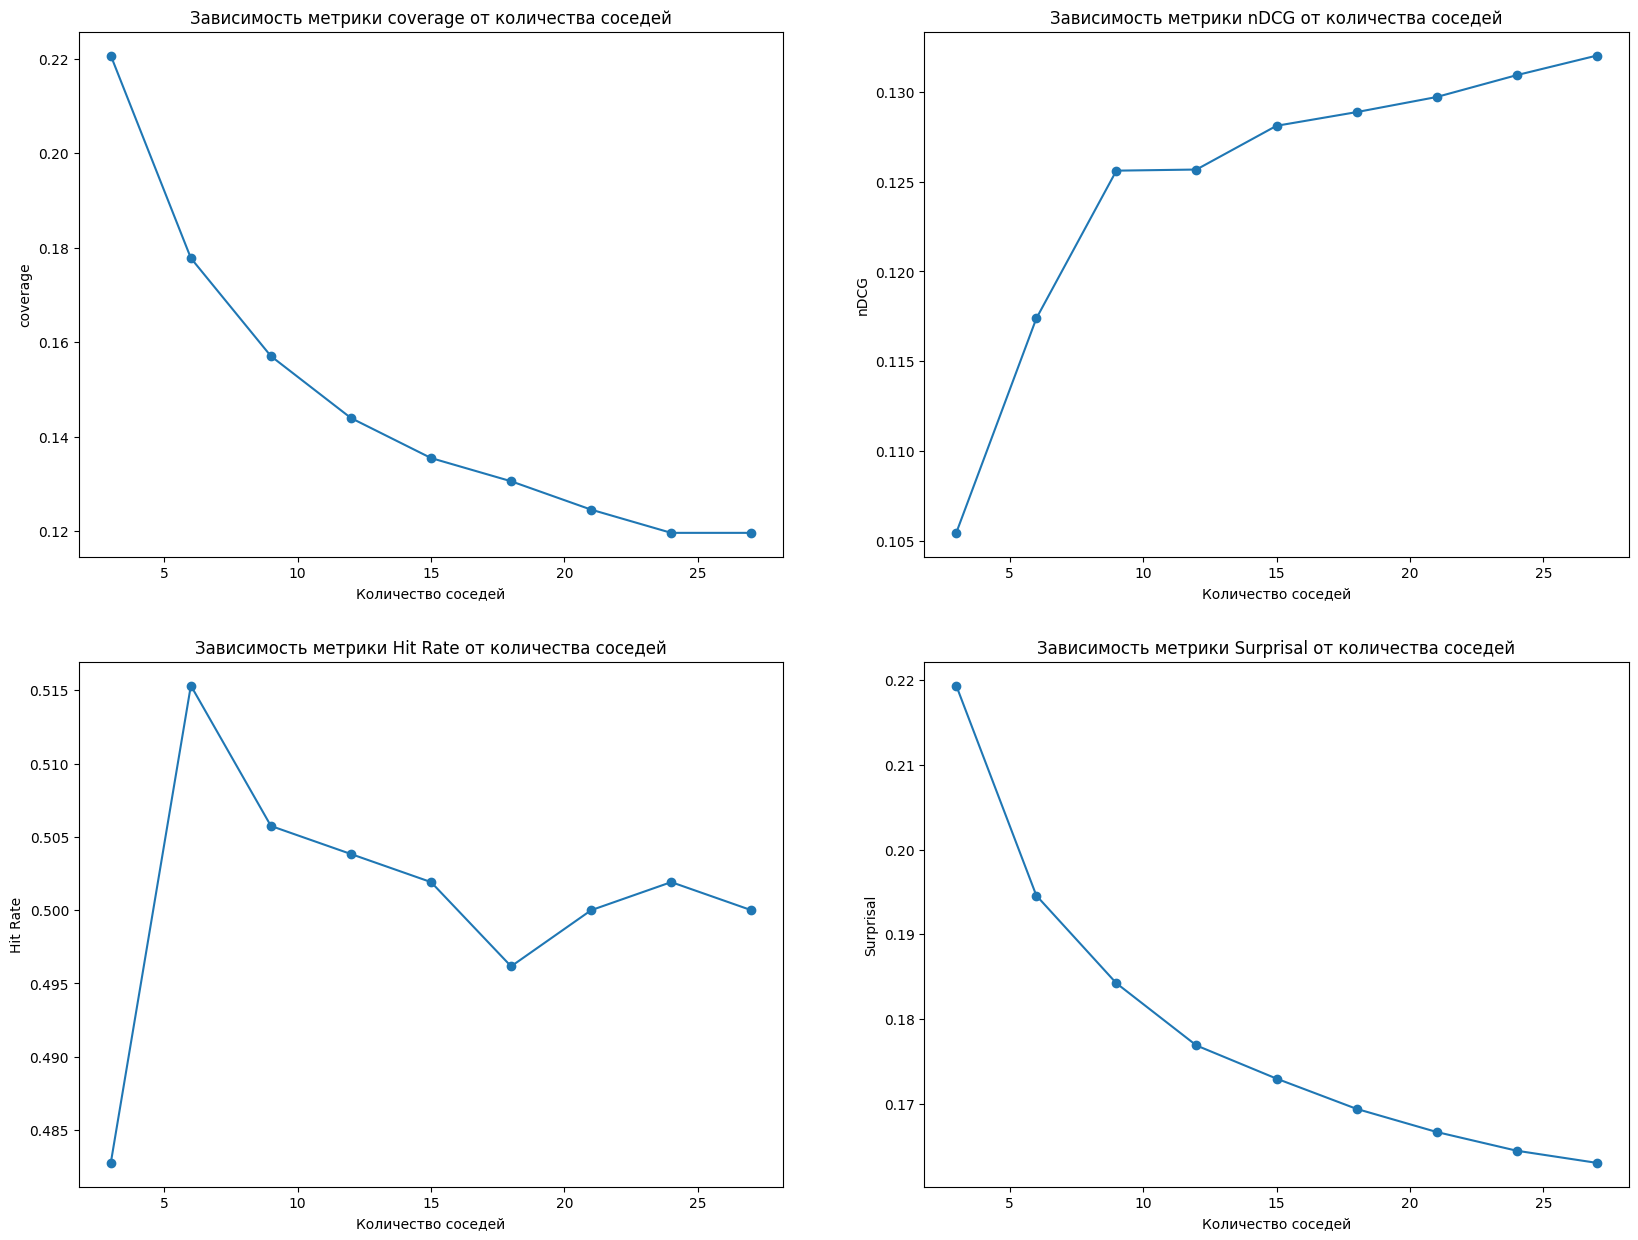

In [350]:
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.scatter(neighbours_amnt, coverage_list)
plt.plot(neighbours_amnt, coverage_list)

plt.xlabel("Количество соседей")
plt.ylabel("coverage")
plt.title(f"Зависимость метрики coverage от количества соседей")

plt.subplot(2,2,2)
plt.scatter(neighbours_amnt, n_dcg_list)
plt.plot(neighbours_amnt, n_dcg_list)

plt.xlabel("Количество соседей")
plt.ylabel("nDCG")
plt.title(f"Зависимость метрики nDCG от количества соседей")

plt.subplot(2,2,3)
plt.scatter(neighbours_amnt, hit_rate_list)
plt.plot(neighbours_amnt, hit_rate_list)

plt.xlabel("Количество соседей")
plt.ylabel("Hit Rate")
plt.title(f"Зависимость метрики Hit Rate от количества соседей")

plt.subplot(2,2,4)
plt.scatter(neighbours_amnt, surprise_list)
plt.plot(neighbours_amnt, surprise_list)

plt.xlabel("Количество соседей")
plt.ylabel("Surprisal")
plt.title(f"Зависимость метрики Surprisal от количества соседей")

Разберем основной смысл использования весов tfidf и bm25. Предположим, что у нас есть пользователи i и j. i-й пользователь дал оценку 100 фильмам, j-й пользователь дал оценку 2м фильмам. Чья рекомендация будет более конструктивной? На уровне элементарной логики, наверное, к i-му пользователю доверия несколько больше, так как у него "больше опыта для сравнения". Нам бы хотелось как-то учесть эту особенность. На данный момент наши модели учитывают подобных пользователей в одинаковой мере.
Необходимо присвоить оценкам пользователей некоторый веса, причем, пользователям, который оценивали больше разных фильмов нужно присвоить бОльшие веса.

In [270]:
tfidf_model = implicit.nearest_neighbours.TFIDFRecommender(200)
tfidf_model.fit(csr_matrix(user_item_train_matrix).T.tocsr(),
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006829500198364258 seconds
  warnings.warn(


  0%|          | 0/5365 [00:00<?, ?it/s]

In [271]:
def get_recommended_movies_info(items_idx_list: list):
  df = data.items[data.items['item_id'].isin(items_idx_list)]
  return df

In [272]:
closest, scores = tfidf_model.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
1004,1017,Swiss Family Robinson (1960),Adventure|Children's
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1412,1437,"Cement Garden, The (1993)",Drama
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1551,1592,Air Bud (1997),Children's|Comedy
2810,2879,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy
2837,2906,Random Hearts (1999),Drama|Romance
2920,2989,For Your Eyes Only (1981),Action
3122,3191,"Quarry, The (1998)",Drama


In [273]:
recommendation = tfidf_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix).tocsr(),
                        N=K,
                        filter_already_liked_items=False,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
438,442,Demolition Man (1993),Action|Sci-Fi
662,668,Pather Panchali (1955),Drama
948,960,Angel on My Shoulder (1946),Crime|Drama
1189,1207,To Kill a Mockingbird (1962),Drama
1208,1226,"Quiet Man, The (1952)",Comedy|Romance
2115,2184,"Trouble with Harry, The (1955)",Mystery|Thriller
2167,2236,Simon Birch (1998),Drama
2644,2713,Lake Placid (1999),Horror|Thriller
3063,3132,Daddy Long Legs (1919),Comedy
3493,3562,Committed (2000),Comedy|Drama


In [274]:
tifidf_recommendations = make_recommendation_table(user_list, tfidf_model, K, user_item_train_matrix)

100%|██████████| 522/522 [05:39<00:00,  1.54it/s]


In [275]:
COVERAGE['tifidf'] = coverage(tifidf_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['tifidf'] = HitRate(tifidf_recommendations, val, K)
N_DCG['tifidf'] = nDCG(tifidf_recommendations, val, K)
SURPRISAL['tifidf'] = surp(tifidf_recommendations, K)

In [276]:
bm25_model = implicit.nearest_neighbours.BM25Recommender(200)
bm25_model.fit(csr_matrix(user_item_train_matrix).T.tocsr(),
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007395029067993164 seconds
  warnings.warn(


  0%|          | 0/5365 [00:00<?, ?it/s]

In [277]:
closest, scores = bm25_model.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
276,279,My Family (1995),Drama
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1290,1310,Hype! (1996),Documentary
1392,1415,"Thieves (Voleurs, Les) (1996)",Crime|Drama|Romance
1412,1437,"Cement Garden, The (1993)",Drama
1551,1592,Air Bud (1997),Children's|Comedy
2810,2879,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy
2837,2906,Random Hearts (1999),Drama|Romance
3619,3688,Porky's (1981),Comedy


In [278]:
recommendation = bm25_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix).tocsr(),
                        N=K,
                        filter_already_liked_items=False,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
341,345,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
995,1008,"Davy Crockett, King of the Wild Frontier (1955)",Western
1189,1207,To Kill a Mockingbird (1962),Drama
1248,1268,Pump Up the Volume (1990),Drama
2167,2236,Simon Birch (1998),Drama
2873,2942,Flashdance (1983),Drama|Romance
3063,3132,Daddy Long Legs (1919),Comedy
3096,3165,Boiling Point (1993),Action|Drama
3424,3493,Torso (Corpi Presentano Tracce di Violenza Car...,Horror
3482,3551,Marathon Man (1976),Thriller


In [279]:
bm25_recommendations = make_recommendation_table(user_list, bm25_model, K, user_item_train_matrix)

100%|██████████| 522/522 [04:24<00:00,  1.97it/s]


In [280]:
COVERAGE['bm25'] = coverage(bm25_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['bm25'] = HitRate(bm25_recommendations, val, K)
N_DCG['bm25'] = nDCG(bm25_recommendations, val, K)
SURPRISAL['bm25'] = surp(bm25_recommendations, K)

В соответствии с исследованием гиперпараметра, возмем наилучшую модель и обучим ее.

In [281]:
knn_model_300 = implicit.nearest_neighbours.CosineRecommender(300)
knn_model_300.fit(csr_matrix(user_item_train_matrix).T.tocsr(),
          show_progress=True)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006036043167114258 seconds
  warnings.warn(


  0%|          | 0/5365 [00:00<?, ?it/s]

Модель обучилась. Теперь можно передать ей индекс некоторого объекта и попросить выдать N наиболее похожых. Давайте попробуем это сделать.

In [282]:
closest, scores = knn_model_300.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
1004,1017,Swiss Family Robinson (1960),Adventure|Children's
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1412,1437,"Cement Garden, The (1993)",Drama
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2810,2879,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy
2837,2906,Random Hearts (1999),Drama|Romance
3122,3191,"Quarry, The (1998)",Drama
3575,3644,Dark Command (1940),Western


Заведем вспомогательную функцию, которая возвращает информацию о фильмах по списку их индексов. Функцию будем использовать, чтобы сравнивать рекомендации с фильмами, которые пользователь реально оценивал.

Выведем названия фильмов

Сгенерируем рекомендации. Для отдельного пользователи получим список рекомендованных для него фильмов.

In [283]:
recommendation = knn_model_300.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix).tocsr(),
                        N=K,
                        filter_already_liked_items=False,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
384,388,Boys Life (1995),Drama
438,442,Demolition Man (1993),Action|Sci-Fi
590,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
626,631,All Dogs Go to Heaven 2 (1996),Animation|Children's|Musical
662,668,Pather Panchali (1955),Drama
929,941,"Mark of Zorro, The (1940)",Adventure
1189,1207,To Kill a Mockingbird (1962),Drama
1208,1226,"Quiet Man, The (1952)",Comedy|Romance
1408,1432,Metro (1997),Action
2568,2637,"Mummy's Hand, The (1940)",Horror


Сгенерируем рекомендации для всех пользователей из валидационной

In [284]:
knn_recommendations = make_recommendation_table(user_list, knn_model_300, K, user_item_train_matrix)

100%|██████████| 522/522 [04:22<00:00,  1.99it/s]


In [285]:
COVERAGE['knn'] = coverage(knn_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['knn'] = HitRate(knn_recommendations, val, K)
N_DCG['knn'] = nDCG(knn_recommendations, val, K)
SURPRISAL['knn'] = surp(knn_recommendations, K)

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

Построим модель ALS. TODO: написать про параметры.

Рассмотрим подробно, за что отвечает каждый из параметров модели:
- factors -- размер первой матрицы в разложении ALS. По-сути, показывает то, на сколько будут большими эмбединги пользователей (как много факторов мы хотим учитывать).
- regularisation -- в представлении не нуждается
- iterations -- количество итераций обучения. В методе ALS мы представляем исходную матрицу user-item произведением двух матриц, которые нам необходимо обучить. Изначально эти матрицы инициализируются случайными весами. Сначала фиксируется одна матрица (без ограничения общности, пусть это будет первая матрица), вторая матрица обучается так, чтобы наилучшим образом приблизить исходную матрицу user-item. Затем фиксируется вторая матрица и оптимизируется первая. Это одна итерация. Параметр iterations отвечает за то, во сколько итераций мы будем оптимизировать матрицы в разложении.

Создадим несколько моделей с различными значениями гиперпараметра (в данном случае будем варьировать количество факторов степенями двойки), чтобы исследовать влияние этого гиперпараметра на оценку модели.

In [302]:
def make_recommendation_table(user_list, model, N, user_item_matrix):
  df = pd.DataFrame()
  for user_id in tqdm(user_list):
    # get a list of recommended items for specific user
    recommended_items = model.recommend(user_id,
                        user_items=csr_matrix(user_item_matrix.T[user_id]).tocsr(), #go to the issue The fix here is to go model.recommend(user_label, sparse_user_items[user_label]) instead of model.recommend(user_label, sparse_user_items)
                        N=N,
                        filter_already_liked_items=False,
                        filter_items=None,
                        recalculate_user=True)
    for item, rel in zip(recommended_items[0], recommended_items[1]):
      new_row = {}
      new_row['user_id'] = user_id
      new_row['item_id'] = item
      new_row['relevance'] = rel
      s = pd.Series(new_row)
      df = pd.concat([df, s.to_frame().T])
  return df

In [319]:
factor_list = [x for x in range(4, 32+1, 4)]

coverage_list = []
n_dcg_list = []
hit_rate_list = []
surprise_list = []

als_models_list = []
for factor in tqdm(factor_list):
  als_models_list.append(
      implicit.als.AlternatingLeastSquares(
          factors=factor,
          regularization=0.0,
          iterations=100)
      )

100%|██████████| 8/8 [00:00<00:00, 32326.04it/s]


In [320]:
for als_model in als_models_list:
  als_model.fit(csr_matrix(user_item_train_matrix).T.tocsr(),
          show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

После обучения всех моделей сделаем рекомендации с помощью каждой из них и посмотрим на оценки.

In [ ]:
for als_model in als_models_list:
  recommendation_table = make_recommendation_table(user_list, als_model, K, user_item_train_matrix)

  coverage_list.append(coverage(recommendation_table, K, train['item_id'].drop_duplicates()))
  n_dcg_list.append(nDCG(recommendation_table, val, K))
  hit_rate_list.append(HitRate(recommendation_table, val, K))
  surprise_list.append(surp(recommendation_table, K))

Построим графики зависимости 4 оценок модели от величины гиперпараметра.

In [ ]:
plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.scatter(factor_list, coverage_list)
plt.plot(factor_list, coverage_list)

plt.xlabel("Количество факторов")
plt.ylabel("coverage")
plt.title(f"Зависимость метрики coverage от количества факторов")

plt.subplot(2,2,2)
plt.scatter(factor_list, n_dcg_list)
plt.plot(factor_list, n_dcg_list)

plt.xlabel("Количество факторов")
plt.ylabel("nDCG")
plt.title(f"Зависимость метрики nDCG от количества факторов")

plt.subplot(2,2,3)
plt.scatter(factor_list, hit_rate_list)
plt.plot(factor_list, hit_rate_list)

plt.xlabel("Количество факторов")
plt.ylabel("Hit Rate")
plt.title(f"Зависимость метрики Hit Rate от количества факторов")

plt.subplot(2,2,4)
plt.scatter(factor_list, surprise_list)
plt.plot(factor_list, surprise_list)

plt.xlabel("Количество факторов")
plt.ylabel("Surprisal")
plt.title(f"Зависимость метрики Surprisal от количества факторов")

В соответствии с исследование выше -- подберем наиболее подходящие гиперпараметры.

In [303]:
als_model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)

Обучаем модель на тренеровочной модели usr-item

In [304]:
als_model.fit(csr_matrix(user_item_train_matrix).T.tocsr(),
          show_progress=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [305]:
closest, scores = als_model.similar_items(TEST_ITEM_ID, N=10)
get_recommended_movies_info(closest)

,item_id,title,genres
181,183,Mute Witness (1994),Thriller
1228,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
1985,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
2810,2879,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy
2837,2906,Random Hearts (1999),Drama|Romance
3122,3191,"Quarry, The (1998)",Drama


In [306]:
recommendation = als_model.recommend(TEST_USER_ID,
                        user_items=csr_matrix(user_item_train_matrix.T[TEST_USER_ID]).tocsr(),
                        N=K,
                        filter_already_liked_items=False,
                        filter_items=None,
                        recalculate_user=True)[0]
get_recommended_movies_info(recommendation)

,item_id,title,genres
24,25,Leaving Las Vegas (1995),Drama|Romance
136,138,"Neon Bible, The (1995)",Drama
178,180,Mallrats (1995),Comedy
343,347,Bitter Moon (1992),Drama
472,476,"Inkwell, The (1994)",Comedy|Drama
990,1003,Extreme Measures (1996),Drama|Thriller
995,1008,"Davy Crockett, King of the Wild Frontier (1955)",Western
1036,1050,Looking for Richard (1996),Documentary|Drama
1848,1917,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller
3017,3086,March of the Wooden Soldiers (a.k.a. Laurel & ...,Comedy


In [300]:
# Compare the output of: user_item_train_matrix[670] and user_item_train_matrix.T[670]

In [307]:
als_recommendations = make_recommendation_table(user_list, als_model, K, user_item_train_matrix)

100%|██████████| 522/522 [00:26<00:00, 19.92it/s]


In [308]:
COVERAGE['als'] = coverage(als_recommendations, K, train['item_id'].drop_duplicates())
HIT_RATE['als'] = HitRate(als_recommendations, val, K)
N_DCG['als'] = nDCG(als_recommendations, val, K)
SURPRISAL['als'] = surp(als_recommendations, K)

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Вспомогательная функция для отрисовки графиков.

In [309]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, round(y, 5), ha='center')

Для каждой из 4 метрик качества: coverage, hit rate, DCG и surprisal построим сравнительные графики для 3 методов предсказаний.

Text(0.5, 1.0, 'SURPRISAL')

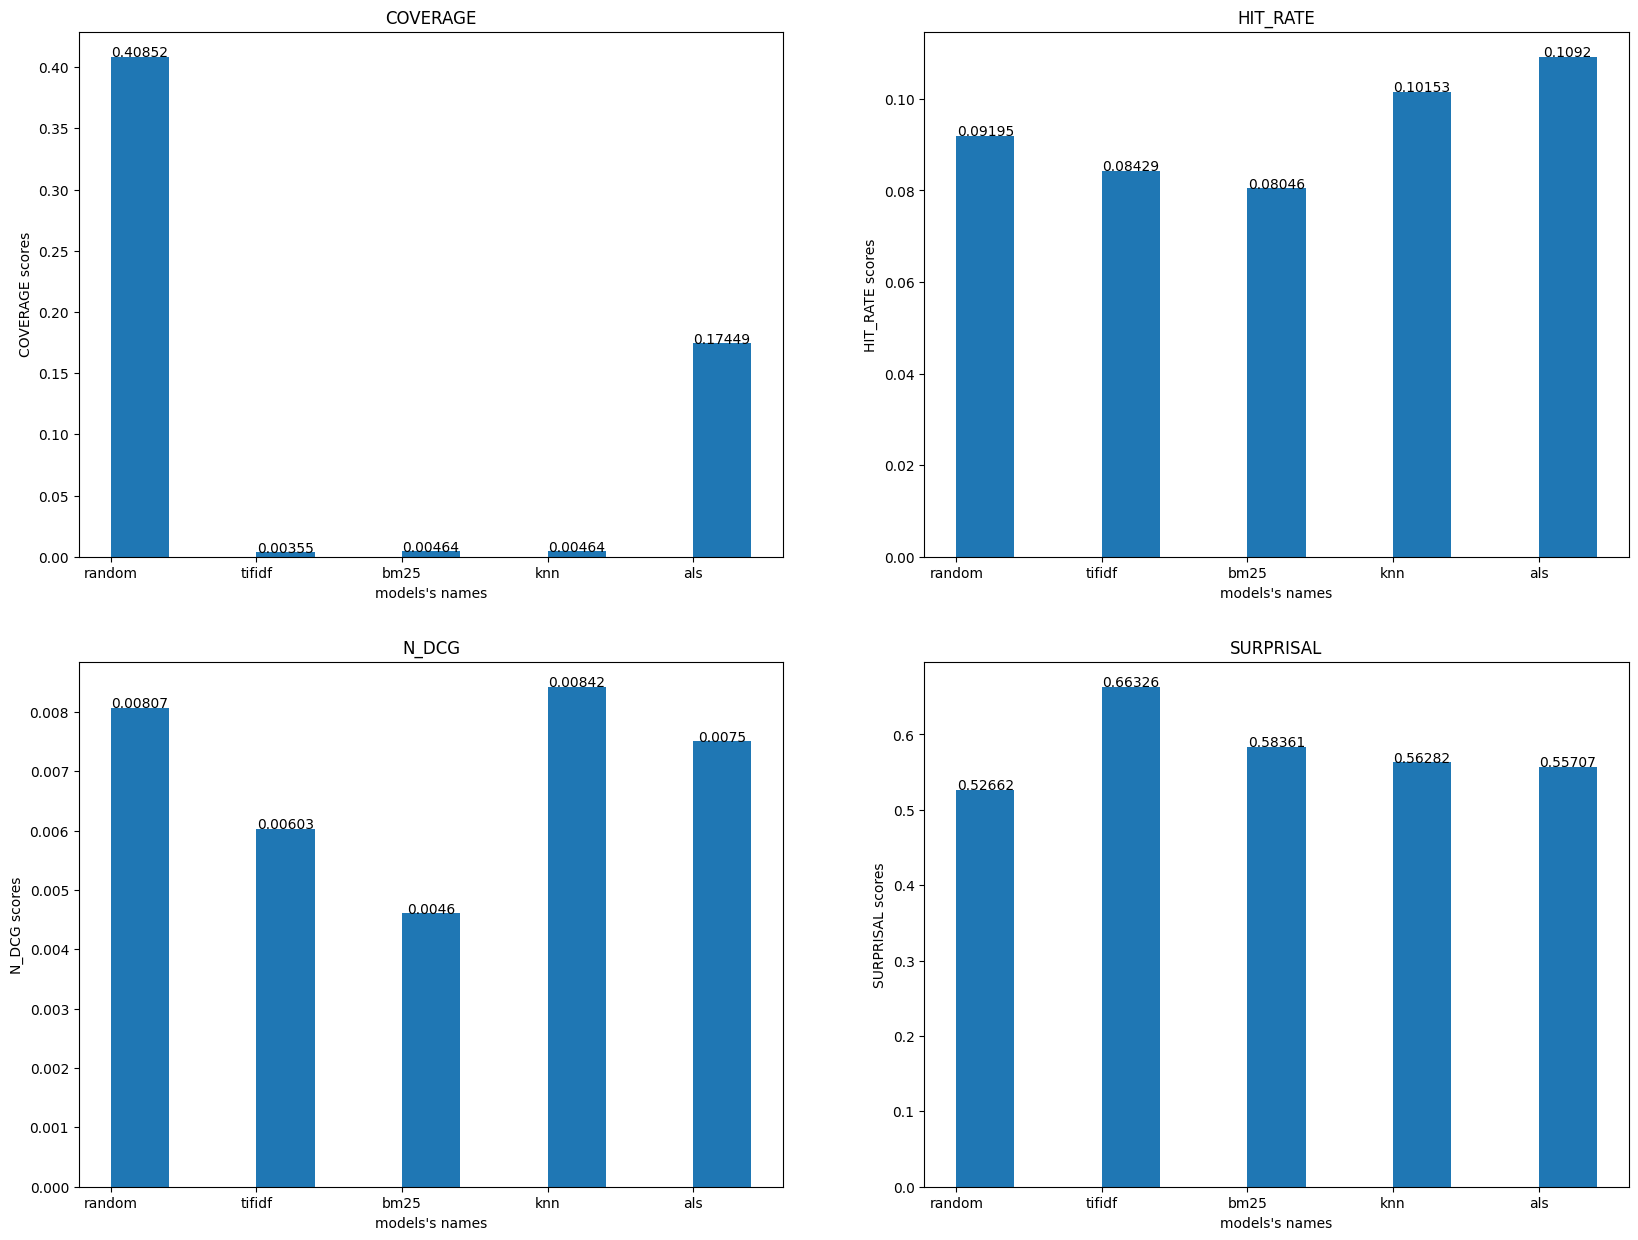

In [310]:
models_names = COVERAGE.keys()

# make x labels for bar plot + some magic for plot view
x_ticks = np.arange(0, len(models_names)*5, 5)
standart_width = 2


plt.figure(figsize=(20, 15))

plt.subplot(2,2,1)
plt.bar(x_ticks + standart_width/2, COVERAGE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, COVERAGE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("COVERAGE scores")
plt.title(f"COVERAGE")

plt.subplot(2,2,2)
plt.bar(x_ticks + standart_width/2, HIT_RATE.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, HIT_RATE.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("HIT_RATE scores")
plt.title(f"HIT_RATE")

plt.subplot(2,2,3)
plt.bar(x_ticks + standart_width/2, N_DCG.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, N_DCG.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("N_DCG scores")
plt.title(f"N_DCG")

plt.subplot(2,2,4)
plt.bar(x_ticks + standart_width/2, SURPRISAL.values(), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, SURPRISAL.values())

plt.xticks(x_ticks, models_names)
plt.xlabel("models's names")
plt.ylabel("SURPRISAL scores")
plt.title(f"SURPRISAL")

Проанализируем полученные результаты. Для начала разберем, в чем состоит сокральный смысл каждой из метрик.
- Surprisal -- показввает, насколько рекомендованные объекты хороши для пользователя с точки зрения "новизны". Скажем, чем больше значение surprisal, тем более рекомендованные объекты являются "уникальными".
- Coverage -- показывает, как много объектов из обучающей выборки используется для рекомендаций. Если coverage маленький, то система рекомендует всем пользователям одни и те же объекты из малого подмножества. Если coverage большой -- система охватывает широкий спектр рекомендуемых пользователю объектов.
- nDCG -- оценивает точность рекомендаций + учитывает порядок расположения объектов в списке рекомендаций.
- Hit rate -- показывает процент релевантных товаров. То есть, какой процент товаров из рекомендованных пользователь реально приобрел.

Сделаем некоторые выводы по наблюдаемым результатам и проделанной работе:
- На примере тестового пользователя можно видеть результат работы каждой ил рекомендательных моделей. Можно посмотреть на список фильмов, просмотренных пользователем, а затем на список рекомендованных ему фильмов. Самый простой способ понять а работает ли вообще рекомендательная модель -- сравнить жанры просмотренных и рекомендованных фильмов. Видно что более менее жанры совпадают, а значит, рекомендательные можели выучили некоторорые зависимоти (довольно логично, что, как правило, конкретный человек предпочитает фильмы конкретных данров).

О трудностях, возникших при выполнении работы.

Библиотека implicit -- основная трудность при выполнении этой работы. Я буду максимально откровенен в своем фидбеке, на сколько это возможно в рамках цензурной лексики. Хотя, тут претензии скорее к разработчикам этой библиотеки. Докуменнтация к ней просто ужасна. Фактически, ее нет. Все, что есть в официальной документации -- максимально краткое описание классов (нет, серьезно, там описания БУКВАЛЬНО в одну строчку), которое и так очевидно следует из названия этого самого класса. Нет ни нормальных описаний методов, ни описаний принимаемых параметров, ни, тем более, примеров использования. С примерами вообще очень тяжко. Мне не удалось найти практически ничего в интернете, ни на kagle и нигде (почему отсутствие примеров это очень больно -- будет понятно дальше).
Таким образом, пришлось лезть в исходные коды библиотеки (чего я как пользователь, по моему личному субъективному мнению делать не должен). И даже на этом цирк не кончается. При правильном, корректном использовании методов, вылезали ошибки, исправить которые удалось, только почитав issues в репозитории той же библиотеки (я даже в работе сослался на конкретный issue в одном месте + вот почему отсутствие примеров использования -- это боль).